In [1]:
import sys
from functools import partial

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder

from adapters import DataAdapter, TfidfVectoriserAdapter
from consts import TARGET_COLUMNS
from estimators import KMeansEstimator, DBSCANEstimator, HDBSCANEstimator, EnhancedHDBSCANEstimator
from my_utils import save, save_result, generate_mappings, nlp_preprocessing
from plotters import PlotterBar, PlotterScatter

unable to import 'smart_open.gcs', disabling that module
C:\CDATA\mine\tmp\my_env2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)
sns.set()  # for plot styling

Python version
3.7.7 (tags/v3.7.7:d7c567b08f, Mar 10 2020, 10:41:24) [MSC v.1900 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)


# Prepare DataSet

In [3]:
@save_result('mydata')
def load_dataset():
    my_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
    print('Training data size:', len(my_data['data']))
    return my_data


@save_result('df', calculate=False)
def prepare_raw_df(mydata, mapping1, mapping2, mapping3):
    df = pd.DataFrame({'data': mydata.data, 'target': mydata.target})
    for mapping, col in zip([mapping1, mapping2, mapping3], TARGET_COLUMNS):
        le = LabelEncoder()
        df[col] = le.fit_transform(df['target'].apply(lambda x: mapping[x]))
        save(dict(enumerate(le.classes_)), col)
    return df.drop(columns=['target']).drop_duplicates().reset_index(drop=True)

In [4]:
dset = load_dataset()
raw_df = prepare_raw_df(dset, *generate_mappings(dset))
raw_df.head()

read mydata
read mappings
read df


,data,clusters,clusters_2,clusters_3
0,\n\nI am sure some bashers of Pens fans are pr...,10,8,3
1,My brother is in the market for a high-perform...,3,3,1
2,\n\n\n\n\tFinally you said what you dream abou...,17,14,6
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,3,1
4,1) I have an old Jasmine drive which I cann...,4,3,1


# Preproccessing DataSet

In [5]:
class PreproccessingAdapter(DataAdapter, PlotterBar):
    pass

In [6]:
adapter = PreproccessingAdapter(raw_df)

# Clusters Frequency

In [7]:
def get_frequency(df, column_name):
    targets, frequency = np.unique(df[column_name], return_counts=True)
    return range(len(targets)), frequency

adapter.plot_clusters(get_frequency, title='Clusters Frequency')

code skipped


<img src="img/Clusters Frequency.png">

In [8]:
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to C:\Users\Andrei_Gavrilov.MO
[nltk_data]     SCOW\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Andrei_Gavri
[nltk_data]     lov.MOSCOW\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
adapter.update_data(nlp_preprocessing(adapter.data))
adapter.data.head()

read preprocessed_df


,data,clusters,clusters_2,clusters_3,word_count,length,word_density,compound,neg,neu,pos
0,I sure bashers Pens fan pretty confuse lack ki...,10,8,3,71,400,5.633803,0.5719,0.244,0.466,0.290
1,My brother market high performance video card ...,3,3,1,39,232,5.948718,0.8225,0.029,0.752,0.219
2,Finally say dream about Mediterranean That new...,17,14,6,161,926,5.751553,-0.9970,0.366,0.555,0.079
3,Think It s SCSI card DMA transfer NOT disk The...,3,3,1,82,476,5.804878,0.9153,0.000,0.822,0.178
4,I old Jasmine drive I use new system My unders...,4,3,1,58,342,5.896552,0.5574,0.000,0.911,0.089


In [10]:
def get_word_density(df, colname, feature):
    tdf = df.groupby([colname]).agg(feature).mean()
    return tdf.index, tdf.values

In [11]:
adapter.plot_clusters(partial(get_word_density, feature='word_density'), title='Clusters word_density')

code skipped


<img src="img/Clusters word_density.png">

In [12]:
adapter.plot_clusters(partial(get_word_density, feature='length'), title='Clusters length');

code skipped


<img src="img/Clusters length.png">

In [13]:
adapter.plot_clusters(partial(get_word_density, feature='word_count'), title='Clusters word_count');

code skipped


<img src="img/Clusters word_count.png">

In [14]:
adapter.clusters_word_cloud('clusters', title='wordcloud_clusters')

code skipped


<img src="img/wordcloud_clusters.png">

In [15]:
adapter.clusters_word_cloud('clusters_2', title='wordcloud_clusters_2')

code skipped


<img src="img/wordcloud_clusters_2.png">

In [16]:
adapter.clusters_word_cloud('clusters_3', title='wordcloud_clusters_3')

code skipped


<img src="img/wordcloud_clusters_3.png">

In [17]:
adapter.data.head()

,data,clusters,clusters_2,clusters_3,word_count,length,word_density,compound,neg,neu,pos
0,I sure bashers Pens fan pretty confuse lack ki...,10,8,3,71,400,5.633803,0.5719,0.244,0.466,0.290
1,My brother market high performance video card ...,3,3,1,39,232,5.948718,0.8225,0.029,0.752,0.219
2,Finally say dream about Mediterranean That new...,17,14,6,161,926,5.751553,-0.9970,0.366,0.555,0.079
3,Think It s SCSI card DMA transfer NOT disk The...,3,3,1,82,476,5.804878,0.9153,0.000,0.822,0.178
4,I old Jasmine drive I use new system My unders...,4,3,1,58,342,5.896552,0.5574,0.000,0.911,0.089


# TF-iDF

In [18]:
class TfidfVectoriserPlotter(TfidfVectoriserAdapter, PlotterScatter):
    pass

adapter = TfidfVectoriserPlotter(adapter.data)

read umap


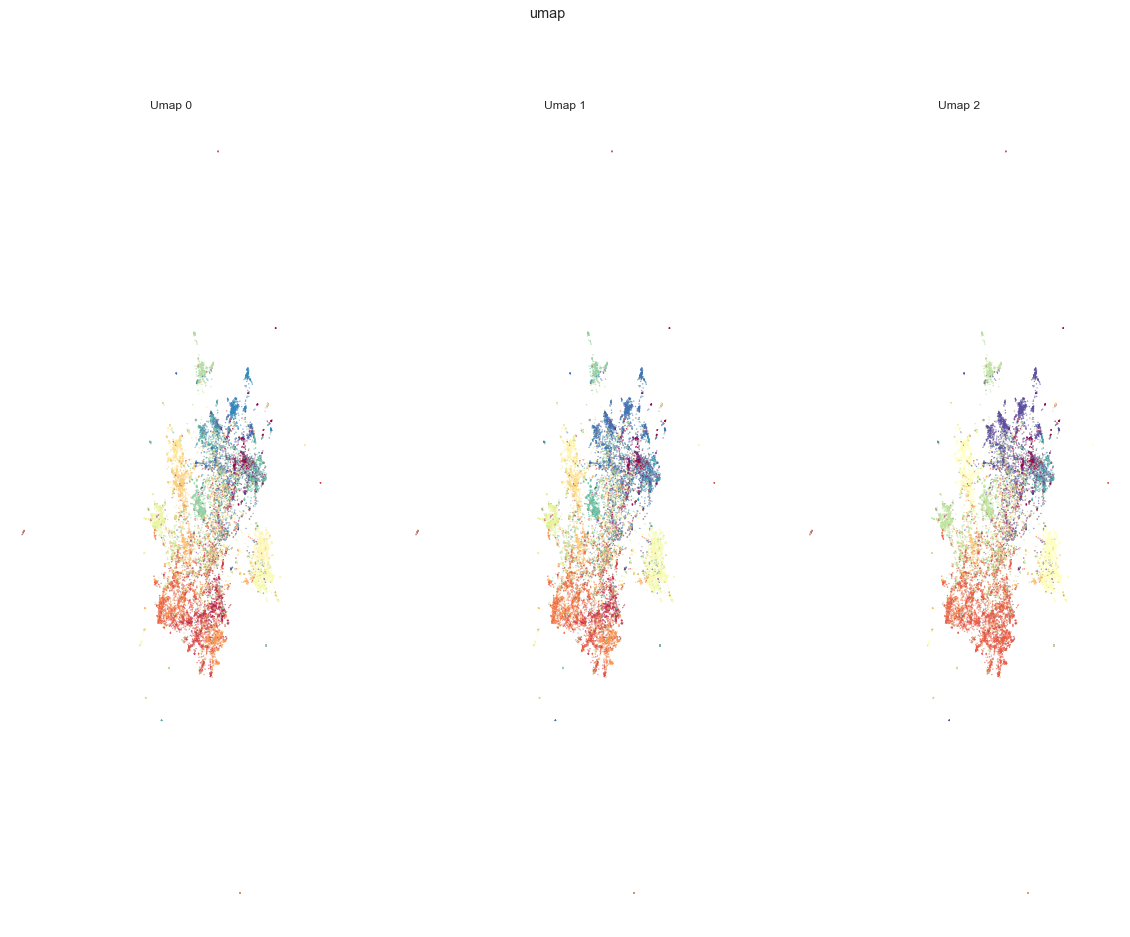

In [19]:
adapter.plot_umap(num=0, title='umap');

read umap_0


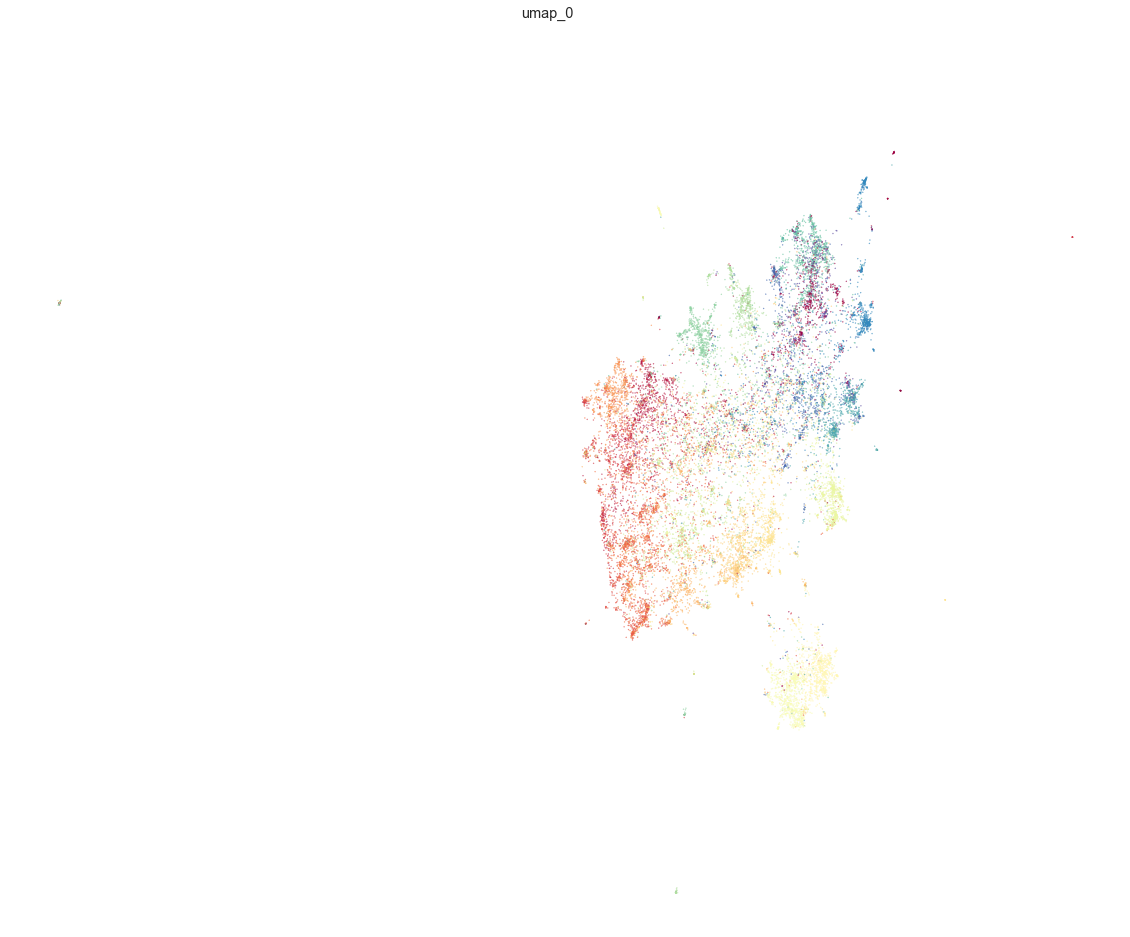

In [20]:
adapter.plot_umap(num=0, title='umap_0');

read umap_1


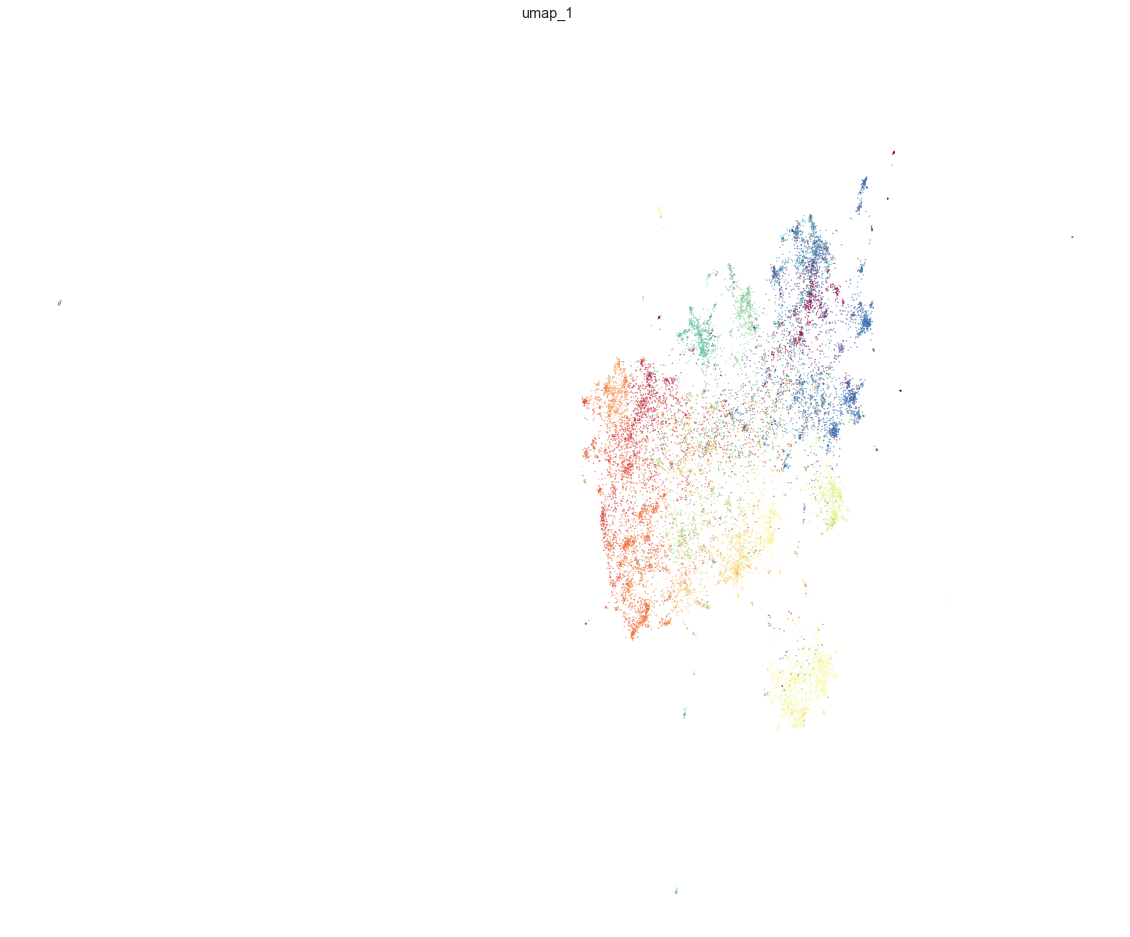

In [21]:
adapter.plot_umap(num=2, title='umap_1');

read umap_2


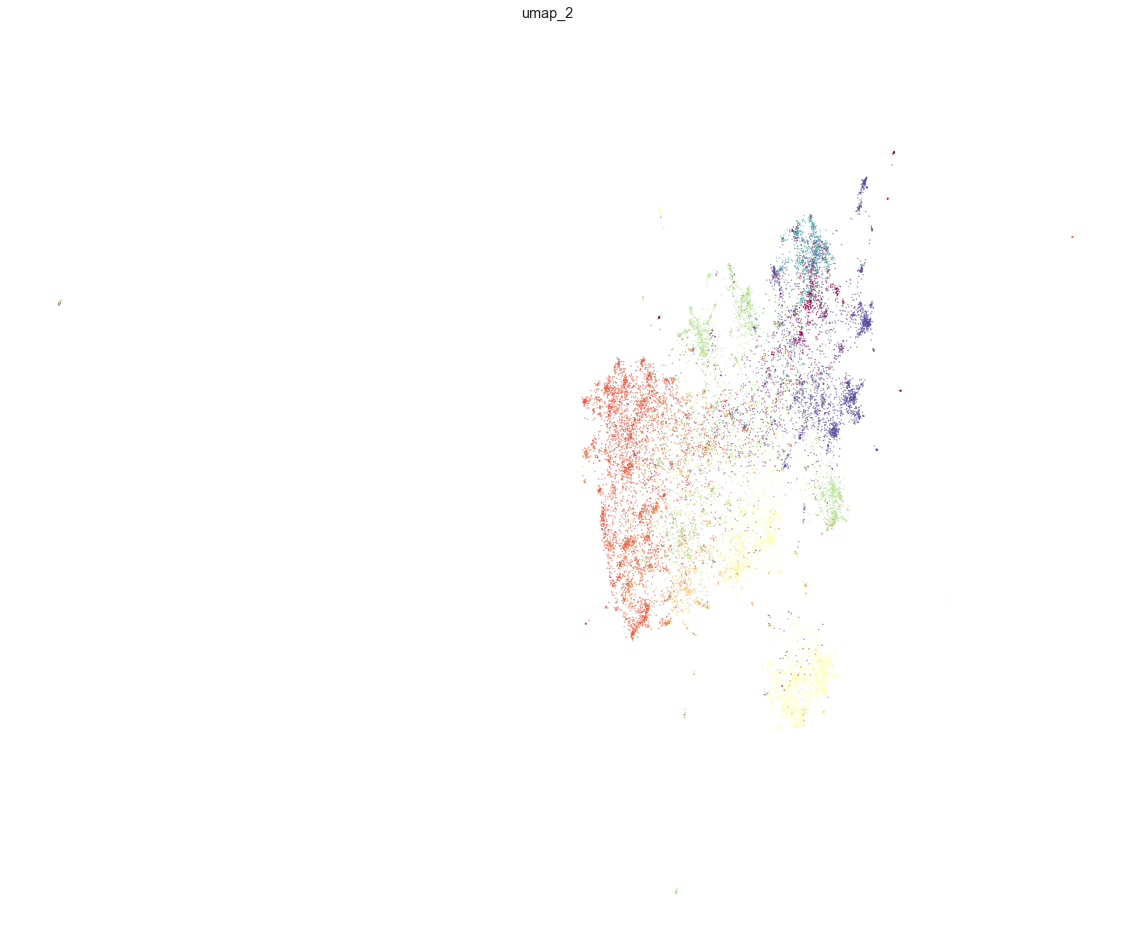

In [22]:
adapter.plot_umap(num=2, title='umap_2');

In [23]:
def reduced_results(df, column_name, svd_df):
    results_pd = pd.concat([df[[column_name]], svd_df], axis=1)
    results_pd = results_pd[results_pd['x'] < 60]
    return results_pd['x'].values, results_pd['y'].values, results_pd[column_name].values

In [24]:
adapter.plot_clusters_svd(reduced_results)

code skipped


<img src="img/scatter plot for clusters SVD.png">

In [25]:
adapter.plot_clusters_svd_deep(reduced_results);

code skipped


<img src="img/scatter plot for clusters SVD & then PCA True 300.png">

In [26]:
adapter.plot_clusters_svd_deep(reduced_results, with_text_features=False, n_components=15);

code skipped


<img src="img/scatter plot for clusters SVD & then PCA False 15.png">

In [27]:
adapter.plot_clusters_svd_deep(reduced_results, with_text_features=False, n_components=300);

code skipped


<img src="img/scatter plot for clusters SVD & then PCA False 300.png">

In [28]:
adapter.plot_clusters_svd_deep(reduced_results, with_text_features=False, n_components=1000);

code skipped


<img src="img/scatter plot for clusters SVD & then PCA False 1000.png">

In [29]:
adapter.illustrate_dendrogram()

read tfidf_wrap_cosdist
code skipped


<img src="img/dendrogram_tfidf_full.png">

In [30]:
adapter.illustrate_dendrogram(mode="not Full")

read tfidf_wrap_cosdist
code skipped


<img src="img/dendrogram_tfidf_truncate_mode_level_p_5_with_ylimit.png">

In [31]:
for num in range(3):
    adapter.clusters_tsne(labels = adapter.get_target(num), title='tsne_{}'.format(num))

code skipped
code skipped
code skipped


<img src="img/tsne_0.png">

<img src="img/tsne_1.png">

<img src="img/tsne_2.png">

In [32]:
class TfidfVectoriserKMeansEstimator(TfidfVectoriserPlotter, KMeansEstimator):
    pass

In [33]:
adapter = TfidfVectoriserKMeansEstimator(adapter.data)

In [34]:
for num in range(3):
    adapter.clusters_tsne(labels = adapter.get_labels(num), num=num, title='tsne_{}_kmeans'.format(num))

read kmenas_20
code skipped
read kmenas_16
code skipped
read kmenas_7
code skipped


In [35]:
adapter.calculate_metrics(0)

read kmenas_20
Homogeneity: 0.277
Completeness: 0.336
V-measure: 0.304
Adjusted Rand Index: 0.068
Adjusted Mutual Information: 0.301


<img src="img/tsne_0_kmeans.png">

In [36]:
adapter.calculate_metrics(1)

read kmenas_16
Homogeneity: 0.304
Completeness: 0.373
V-measure: 0.335
Adjusted Rand Index: 0.090
Adjusted Mutual Information: 0.333


<img src="img/tsne_1_kmeans.png">

In [37]:
adapter.calculate_metrics(2)

read kmenas_7
Homogeneity: 0.239
Completeness: 0.287
V-measure: 0.261
Adjusted Rand Index: 0.099
Adjusted Mutual Information: 0.260


<img src="img/tsne_2_kmeans.png">

# Unknown number of clusters

read number_of_clusters_visualizer


C:\CDATA\mine\tmp\my_utils.py:28: UserWarning: This figure was saved with matplotlib version 3.0.3 and is unlikely to function correctly.
  return pickle.load(handle)
C:\CDATA\mine\tmp\my_env2\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


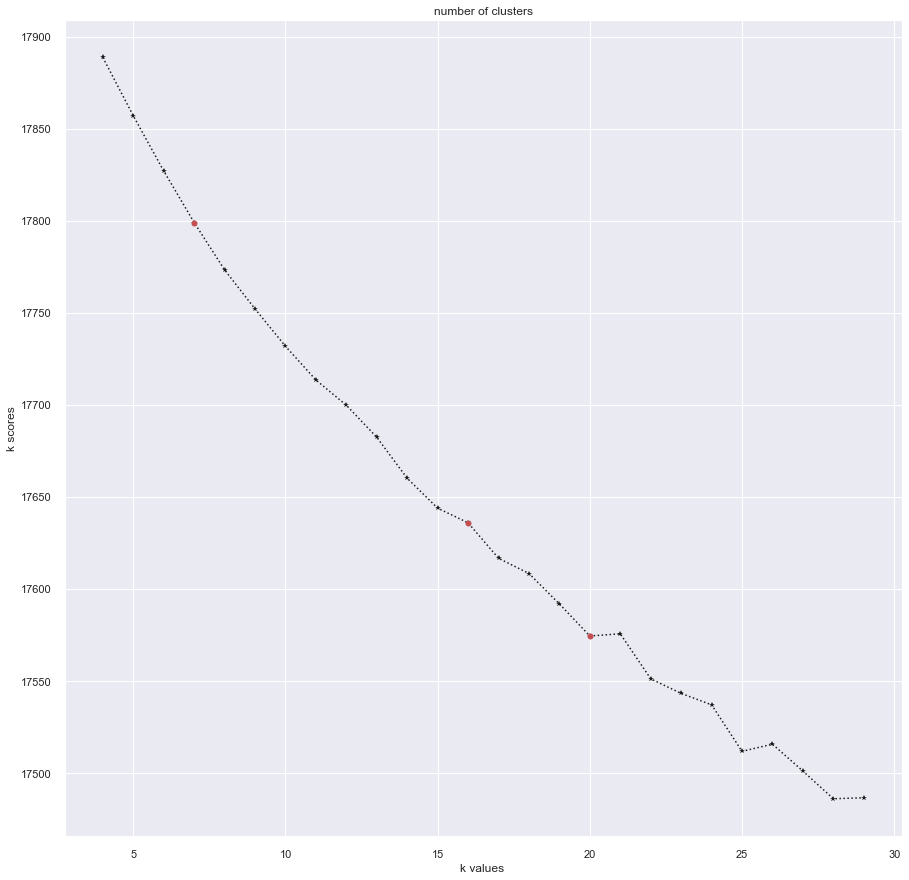

In [38]:
adapter.plot_clusters_scores()

In [39]:
class TfidfVectoriserDBSCANEstimator(TfidfVectoriserPlotter, DBSCANEstimator):
    pass

In [40]:
TfidfVectoriserDBSCANEstimator.__mro__

(__main__.TfidfVectoriserDBSCANEstimator,
 __main__.TfidfVectoriserPlotter,
 adapters.TfidfVectoriserAdapter,
 adapters.DataAdapter,
 plotters.PlotterScatter,
 plotters.Plotter,
 estimators.DBSCANEstimator,
 estimators.Estimator,
 abc.ABC,
 object)

In [41]:
adapter = TfidfVectoriserDBSCANEstimator(adapter.data)

In [42]:
adapter.calculate_metrics()

read DBSCAN_eps_0.8_min_samples_10
Homogeneity: 0.011
Completeness: 0.032
V-measure: 0.016
Adjusted Rand Index: 0.015
Adjusted Mutual Information: 0.015


In [43]:
adapter.clusters_tsne(labels = adapter.get_labels(0), title='tsne_DBSCAN')

read DBSCAN_eps_0.8_min_samples_10
code skipped


<img src="img/tsne_DBSCAN.png">

In [44]:
# pd.DataFrame(
#     np.array(adapter.Dbscan_CV(eps_space = np.arange(0.1, 5, 0.1),
#                   min_samples_space = np.arange(1, 50, 1),
#                   file_name="dbscan_clusters_first")), 
#     columns=['Eps','samples_val','num_clusters']).head()

In [45]:
pd.DataFrame(
    np.array(adapter.Dbscan_CV(eps_space = np.arange(0.025, 1.0, 0.025),
                               min_samples_space = np.arange(1, 20, 1),
                               file_name="dbscan_clusters_second")), 
    columns=['eps','samples_val','num_clusters'])

read dbscan_clusters_second


,eps,samples_val,num_clusters
0,0.800,5.0,18.0
1,0.800,6.0,15.0
2,0.800,7.0,17.0
3,0.800,8.0,12.0
4,0.800,9.0,11.0
5,0.800,10.0,6.0
6,0.825,3.0,9.0
7,0.850,2.0,21.0


In [46]:
# for param in adapter.params_generator():
#     adapter.set_params(param)
#     print(param)
#     adapter.calculate_metrics()
#     adapter.clusters_tsne(labels = adapter.get_labels(0), title='tsne_{}'.format(adapter.estimator_name()))

In [47]:
class TfidfVectoriserHDBSCANEstimator(TfidfVectoriserPlotter, HDBSCANEstimator):
    pass

In [48]:
adapter = TfidfVectoriserHDBSCANEstimator(adapter.data)

In [49]:
adapter.calculate_metrics()

read HDBSCAN_eps_0.8_min_samples_10_min_cluster_size_100
Homogeneity: 0.018
Completeness: 0.105
V-measure: 0.031
Adjusted Rand Index: -0.002
Adjusted Mutual Information: 0.031


read umap_hdbscan_min_cluster_size_100_2


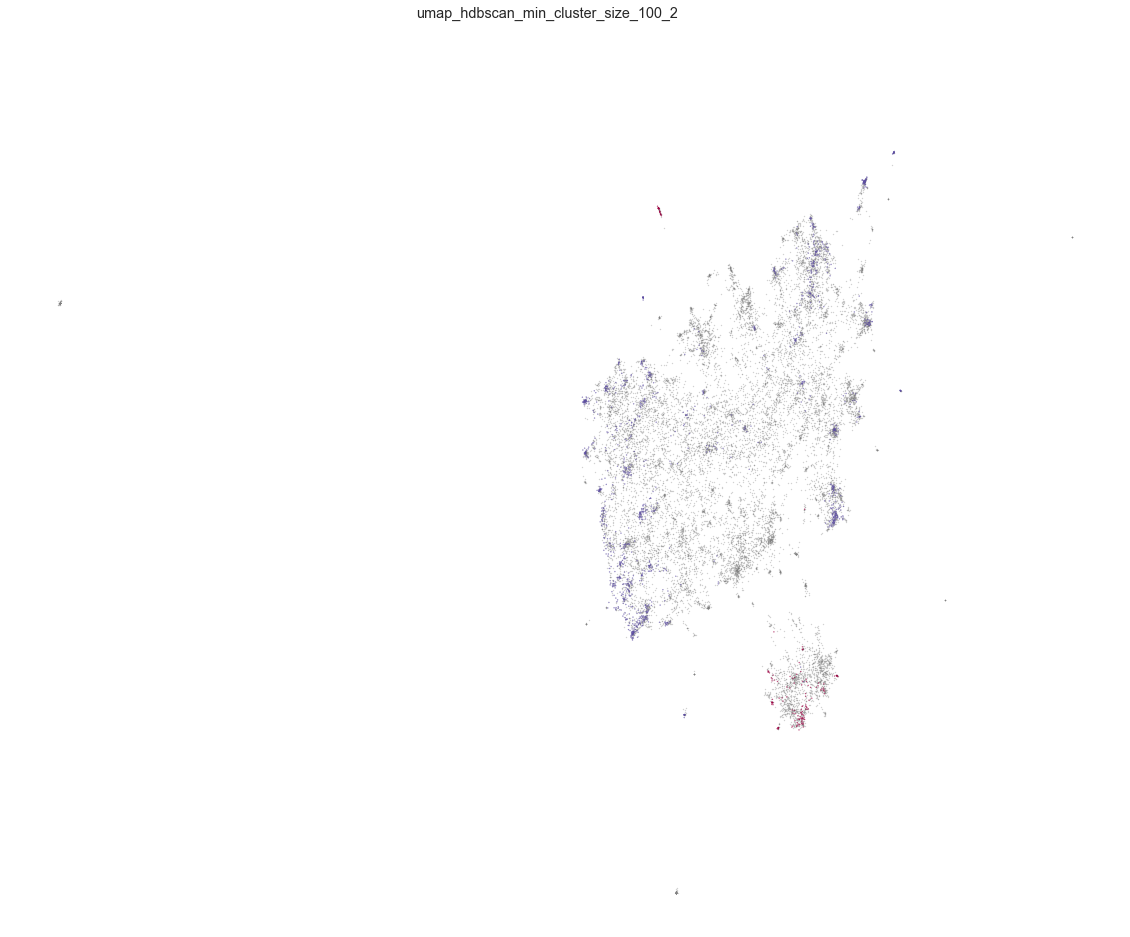

In [50]:
adapter.plot_umap(title='umap_hdbscan_min_cluster_size_100_2', target=False);

In [51]:
adapter.set_params({'min_cluster_size': 10})
adapter.calculate_metrics()

read HDBSCAN_eps_0.8_min_samples_10_min_cluster_size_10
Homogeneity: 0.001
Completeness: 0.019
V-measure: 0.001
Adjusted Rand Index: -0.000
Adjusted Mutual Information: 0.000


read umap_hdbscan_min_cluster_size_10_2


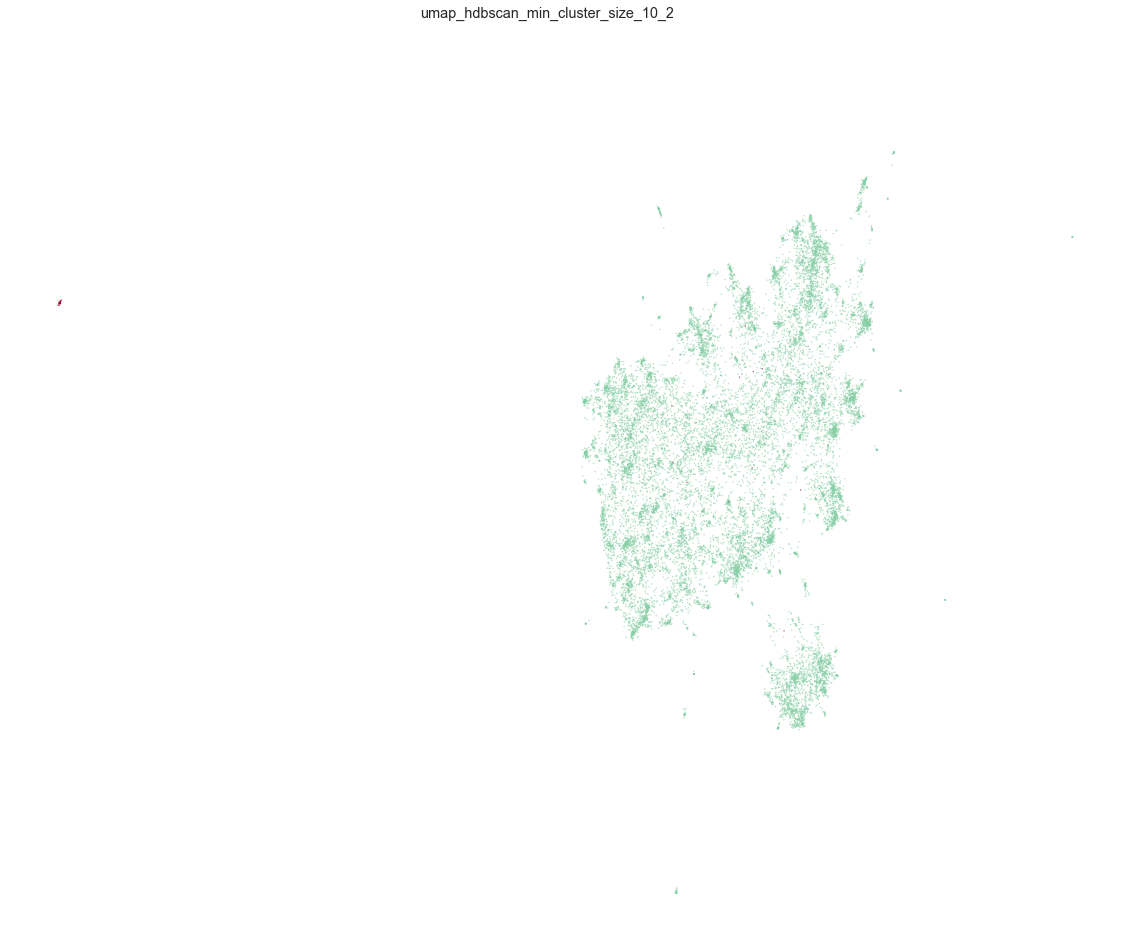

In [52]:
adapter.plot_umap(title='umap_hdbscan_min_cluster_size_10_2', target=False);

In [53]:
class EnhancedTfidfVectoriserHDBSCANEstimator(TfidfVectoriserPlotter, EnhancedHDBSCANEstimator):
    pass

In [54]:
adapter = EnhancedTfidfVectoriserHDBSCANEstimator(adapter.data)
adapter.set_params({'metric': 'euclidean'})

In [55]:
adapter.calculate_metrics()

read EnhancedHDBSCANEstimator_eps_0.8_min_samples_10_min_cluster_size_100
Homogeneity: 0.000
Completeness: 0.003
V-measure: 0.000
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000


read Enhanced_umap_hdbscan_min_cluster_size_100_2


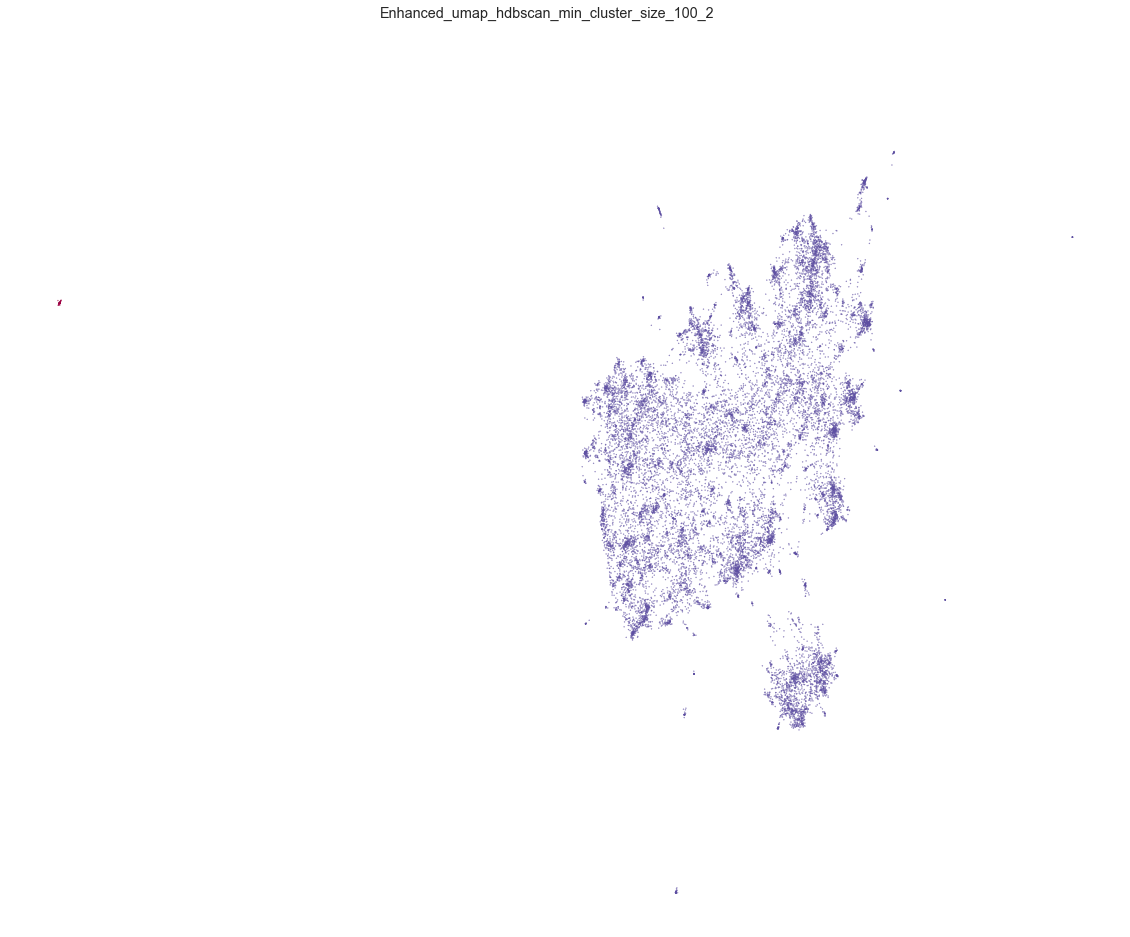

In [56]:
adapter.plot_umap(title='Enhanced_umap_hdbscan_min_cluster_size_100_2', target=False);

In [57]:
adapter.set_params({'min_cluster_size': 10})
adapter.calculate_metrics()

read EnhancedHDBSCANEstimator_eps_0.8_min_samples_10_min_cluster_size_10
Homogeneity: 0.007
Completeness: 0.131
V-measure: 0.014
Adjusted Rand Index: -0.000
Adjusted Mutual Information: 0.013


read Enhanced_umap_hdbscan_min_cluster_size_10_2


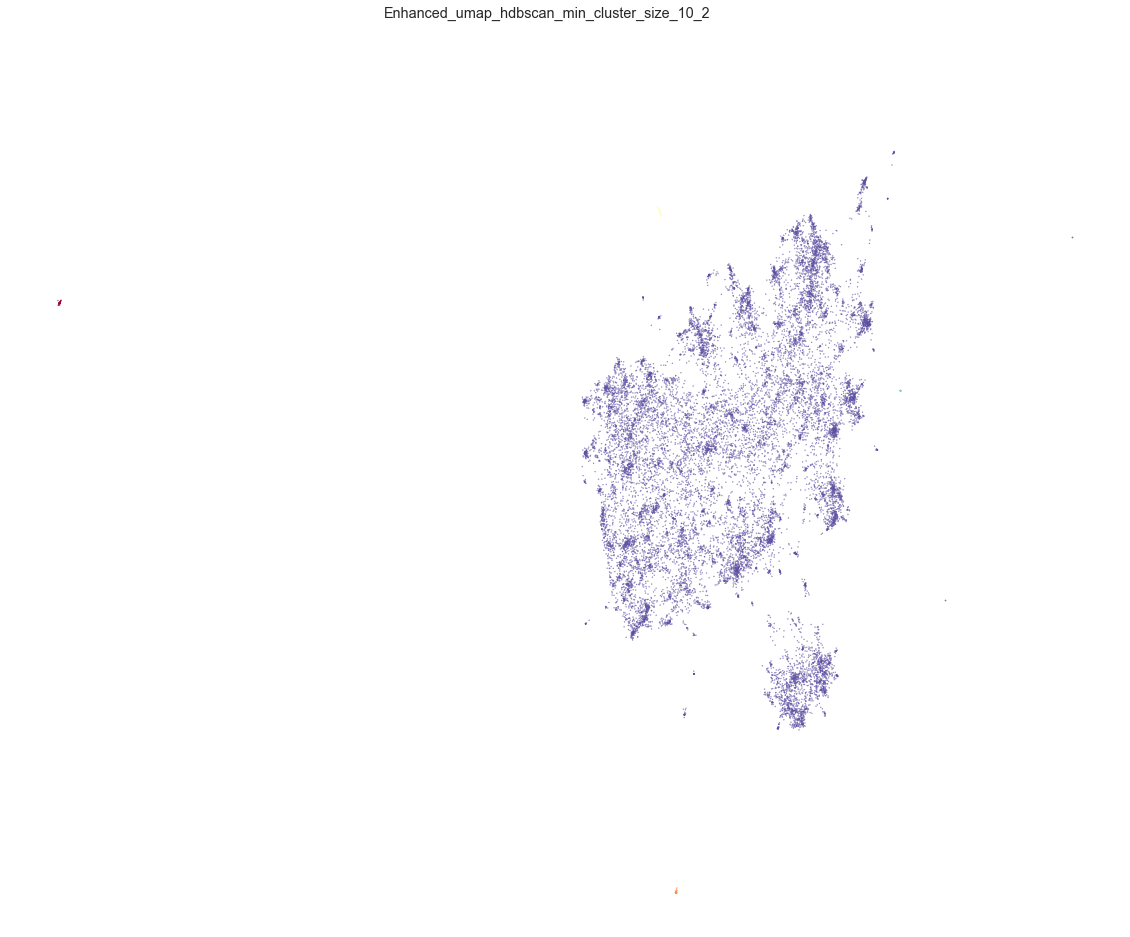

In [58]:
adapter.plot_umap(title='Enhanced_umap_hdbscan_min_cluster_size_10_2', target=False);